# Notebook pour projet DCD

## Roadmap

1 - Import all metrics in an array of shape *metrics* × *species* × *values*

2 - Cluster *species* × *values* for each metric then compare to orthologs

In [1]:
import sklearn.cluster
import matplotlib.pyplot as plt
import numpy
import pandas
import glob
import seaborn as sns

## 1 - Import

In [2]:
arraylist = list()
metrics_list = glob.glob("Metrics/*.tsv")
for filename in metrics_list:
    csv_df = pandas.read_csv(filename, delimiter = "\t", index_col=0)
    arraylist.append(csv_df)

In [3]:
np_list = list()
for array in arraylist:
    shape = array.shape
    array_nonacol = array.dropna(axis=0, thresh = shape[1] - 10000)
    array_nona = array_nonacol.dropna(axis = 1)
    np_list.append(array_nona)

In [4]:
# we need all rows and columns names that are not common to all the arrays
columns = set(np_list[0].columns)
rows = set(np_list[0].index)
cols_todel = list()
rows_todel = list()

for array in np_list: # first get all common elements
    rows = rows.intersection(set(array.index))
    columns = columns.intersection(set(array.columns))

for array in np_list: # then get the diff for each array
    rows_todel.append(set(array.index) - rows)
    cols_todel.append(set(array.columns) - columns)

In [5]:
stackable_arrays = list()
for array, rows, cols in zip(np_list, rows_todel, cols_todel):
    temp = array.drop(index=rows)
    stackable_arrays.append(temp.drop(columns = cols))

In [6]:
stacked_arrays = numpy.stack([i.to_numpy() for i in stackable_arrays])
stacked_arrays.shape

(4, 57, 597)

## 2 - Cluster for each metric then compare to orthologs

### Cluster

In [7]:
# from metrics : species : genes to genes : metrics
to_merge = list()
for i in range(stacked_arrays.shape[1]):
    to_merge.append(stacked_arrays[:,i,:].transpose())
genes_x_metrics = numpy.concatenate(to_merge)
genes_x_metrics.shape

(34029, 4)

In [8]:
sc = sklearn.cluster.OPTICS(min_samples=57).fit(genes_x_metrics)
max(sc.labels_)

34

### Compare

Create a count cluster : labels

In [10]:
labels = list()
for i in range(stacked_arrays.shape[1]):
    labels += list(stackable_arrays[0].columns)

In [13]:
counts_by_labels = dict()
for cluster, label in zip(sc.labels_, labels):
    if cluster not in counts_by_labels:
        counts_by_labels[cluster]=dict()
    if label not in counts_by_labels[cluster]:
        counts_by_labels[cluster][label]=0
    counts_by_labels[cluster][label] += 1

Then graph it : as a plotly sunburst

In [25]:
sunburst_data = {"name": list(), "parent": list(), "value": list()}
for cluster in counts_by_labels:
    if not cluster == -1:
        for label in counts_by_labels[cluster]:
            sunburst_data["name"].append(label)
            sunburst_data["parent"].append(cluster)
            sunburst_data["value"].append(counts_by_labels[cluster][label])

In [26]:
import plotly.express as px
# parent is cluster
# character is ortholog
# values is count character by cluster
fig =px.sunburst(
    sunburst_data,
    names='name',
    parents='parent',
    values='value',
)
fig.show(renderer = "browser")

In [ ]:
As a stacked barplot:

In [27]:
fig = px.bar(sunburst_data, x="parent", y="value", color="name")
fig.show(renderer="browser")

In [47]:
#array_graph = numpy.stack(([i.split("/")[1].split(".")[0] for i in metrics_list], sc.labels_))
array_graph = numpy.stack((stackable_arrays[0].columns.to_numpy(), sc.labels_))
array_graph

array([['4922', '163786', '65977', ..., '56892', '26061', '8417'],
       [0, 144, 114, ..., 90, 20, 155]], dtype=object)

In [48]:
df_graph = pandas.DataFrame(array_graph.transpose(), columns = ["File", "Cluster"])
df_graph["Cluster"] = pandas.to_numeric(df_graph["Cluster"])
df_graph

,File,Cluster
0,4922,0
1,163786,144
2,65977,114
3,414149,3
4,7342,174
...,...,...
592,55632,168
593,5480,19
594,56892,90
595,26061,20


([<matplotlib.axis.YTick at 0x7f9ff9326c70>,
 [Text(0, 1, '57221'),
  Text(0, 2, '80271'),
  Text(0, 3, '9317'),
  Text(0, 4, '2775'),
  Text(0, 5, '3363'),
  Text(0, 6, '9545'),
  Text(0, 7, '8287'),
  Text(0, 8, '7103'),
  Text(0, 9, '84878'),
  Text(0, 10, '84307'),
  Text(0, 11, '51317'),
  Text(0, 12, '64375'),
  Text(0, 13, '8538'),
  Text(0, 14, '9971'),
  Text(0, 15, '79642'),
  Text(0, 16, '83903'),
  Text(0, 17, '151963'),
  Text(0, 18, '92591'),
  Text(0, 19, '57134'),
  Text(0, 20, '27123'),
  Text(0, 21, '201294'),
  Text(0, 22, '9175'),
  Text(0, 23, '647309'),
  Text(0, 24, '51232'),
  Text(0, 25, '9992'),
  Text(0, 26, '6237'),
  Text(0, 27, '79899'),
  Text(0, 28, '125336'),
  Text(0, 29, '977'),
  Text(0, 30, '65055'),
  Text(0, 31, '128869'),
  Text(0, 32, '55750'),
  Text(0, 33, '2984'),
  Text(0, 34, '64377'),
  Text(0, 35, '145389'),
  Text(0, 36, '3284'),
  Text(0, 37, '84787'),
  Text(0, 38, '10121'),
  Text(0, 39, '7133'),
  Text(0, 40, '54913'),
  Text(0, 41, 

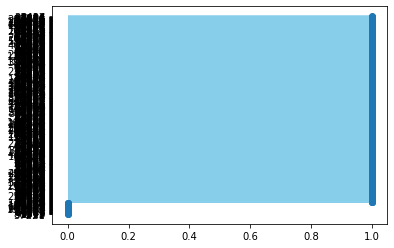

In [41]:
ordered_df = df_graph.sort_values(by='Cluster')
my_range=range(1,len(df_graph.index)+1)
plt.hlines(y=my_range, xmin=0, xmax=ordered_df['Cluster'], color='skyblue')
plt.plot(ordered_df['Cluster'], my_range, "o")
plt.yticks(my_range, ordered_df['File'])

In [60]:
[list(df_graph["Cluster"]).count(i) for i in set(df_graph["Cluster"])]

[3,
 6,
 6,
 3,
 2,
 4,
 4,
 2,
 3,
 2,
 4,
 2,
 4,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 4,
 3,
 2,
 2,
 2,
 2,
 2,
 3,
 5,
 2,
 2,
 2,
 3,
 3,
 3,
 2,
 3,
 4,
 3,
 3,
 3,
 2,
 2,
 3,
 2,
 3,
 2,
 2,
 3,
 3,
 3,
 2,
 5,
 4,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 5,
 3,
 3,
 4,
 2,
 2,
 2,
 2,
 3,
 2,
 3,
 3,
 6,
 4,
 4,
 4,
 3,
 3,
 2,
 3,
 3,
 3,
 2,
 3,
 3,
 2,
 3,
 4,
 2,
 3,
 2,
 3,
 4,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 4,
 3,
 2,
 4,
 5,
 2,
 2,
 2,
 2,
 4,
 5,
 2,
 3,
 4,
 3,
 2,
 3,
 3,
 3,
 3,
 4,
 2,
 2,
 2,
 3,
 5,
 4,
 5,
 2,
 2,
 2,
 2,
 3,
 2,
 2,
 3,
 2,
 3,
 5,
 2,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 4,
 3,
 2,
 2,
 3,
 3,
 2,
 3,
 2,
 4,
 4,
 2,
 2,
 3,
 2,
 3,
 5,
 3,
 2,
 3,
 2,
 2,
 2,
 3,
 6,
 2,
 3,
 2,
 2,
 2,
 2,
 3,
 3,
 6,
 6,
 3,
 3,
 2,
 4,
 42]

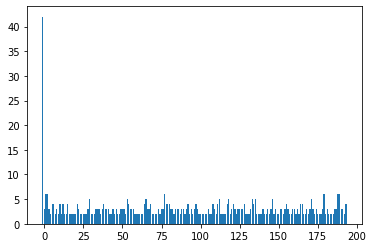

In [80]:
unique_values = [list(df_graph["Cluster"]).count(i) for i in set(df_graph["Cluster"])]
labels = list(set(df_graph["Cluster"]))
plt.bar(x = labels, height = unique_values)
plt.show()

In [78]:
labels = list(set(df_graph["Cluster"]))
numpy.array(labels).shape

(195,)

In [79]:
unique_values = [list(df_graph["Cluster"]).count(i) for i in set(df_graph["Cluster"])]
numpy.array(unique_values).shape

(195,)